In [126]:
import itertools
from rosemary import jpt_in_notebook
from llm.submit import submit_job, multiline_to_singleline

shell_scripts_template = """
echo "Running on $SLURM_JOB_NODELIST"
echo "======"

master_addr=$(scontrol show hostnames "$SLURM_JOB_NODELIST" | head -n 1)
master_port=10002
RDZV_ENDPOINT=$master_addr:$master_port

source ~/.profile
conda activate open-instruct
cd /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts

set -e
set -x
echo "======"
srun {cmd}

[ ! -f "{log_dir}/$SLURM_JOB_ID*.out" ] && mv {log_dir}/$SLURM_JOB_ID*.out {save_dir}
"""

test_run = False
save_dir = "/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b/"
log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

    
dataset_list = ['flan_v2', 'tulu_v1_human_mix', 'tulu_v2_human_mix']
dataset_list = ['flan_v2']
sort_by_list = [
     # kmeans
    'kmeansl2_nc=100', 'kmeansl2_nc=1000', 'kmeansl2_nc=10000',
    'prob',
    'dppmap_k=Kcos', 'dppmap_k=Kcosp', 'dppmap_k=Kcos1np', 
]

options_list = itertools.product(dataset_list, sort_by_list)

    
for dataset, sort_by in options_list:
    cmd = f"""
     python note_explore_data_pruning.py \
        --dataset {dataset} \
        --sort_by {sort_by} \
        --save_dir {save_dir} \
        --test_run \
    """.strip()
    cmd = multiline_to_singleline(cmd)
    shell_scripts = shell_scripts_template.format(
        cmd=cmd, log_dir=log_dir, save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'prune.{dataset}.{sort_by}', 
        nodes=1,
        num_cpus=32,
        cpu_mem=64,
        num_gpus=6,
        gpu_type='v100',
        test_run=test_run,
        job_duration=6,
    )
    if not test_run:
        print(out)




Submiting job with:
{
    "job_name": "prune.flan_v2.kmeansl2_nc=100",
    "nodes": 1,
    "num_cpus": 32,
    "cpu_mem": 64,
    "num_gpus": 6,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
[{'args': 'sbatch --job-name=prune.flan_v2.kmeansl2_nc=100 --partition=el8 --nodes=1 --ntasks-per-node=1 --cpus-per-task=32 --mem=64GB --gres=gpu:6 --output=/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/%J.out --time=6:00:00 /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/tmpka225pxl', 'job_id': 964290}]

Submiting job with:
{
    "job_name": "prune.flan_v2.kmeansl2_nc=1000",
    "nodes": 1,
    "num_cpus": 32,
    "cpu_mem": 64,
    "num_gpus": 6,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
[{'args': 'sbatch --job-name=prune.flan_v2.kmeansl2_nc=1000 --partition=el8 --nodes=1 --ntasks-per-node=1 --cpus-per-task=32 --mem=64GB --gres=gpu:6 --output=/gpfs

In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5'
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


In [117]:
import os
import sys
import numpy as np
import time
import re

import pickle
from tqdm import tqdm 

import pyarrow
import torch
import transformers

from note_explore_data_pruning import (
    save_to_pickle,
    save_sorted_inds,
    sort_kmeans_l2_to_prototypes,
    sort_dpp_map,)

In [118]:
test_run = True
dataset = 'tulu_v1_human_mix'

# ['kmeansl2_nc=100', 'kmeansl2_nc=1000', 'kmeansl2_nc=10000']
# sort_by = 'kmeansl2_nc=100'
# sort_by = 'prob'
# sort_by = 'dppmap_k=Kcos'
# sort_by = 'dppmap_k=Kcos1np'

save_dir = f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b/{dataset}/'
os.makedirs(save_dir, exist_ok=True)

lm_output_dir = "/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/llama-7b_outputs/"

In [119]:

save_path = os.path.join(lm_output_dir, f'{dataset}.pkl')
with open(save_path, 'rb') as f:
    d = pickle.load(f)
# some entries are nan, impute with mean value.
d['log_probs'] = np.nan_to_num(d['log_probs'], nan=np.nanmean(d['log_probs']))
text_embeddings = d['text_embeddings']
log_probs = d['log_probs'].squeeze()

if test_run:
    text_embeddings = text_embeddings[:1000]
    log_probs = log_probs[:1000]


In [120]:


if sort_by.startswith('kmeansl2'):
    match = re.search(r'(?<=\=)\d+', sort_by)
    n_clusters = int(match.group()) if match else None
    S = sort_kmeans_l2_to_prototypes(text_embeddings, n_clusters)
elif sort_by == 'prob':
    S = log_probs
elif sort_by.startswith('dpp'):
    match = re.search(r'k=(\w+)', sort_by)
    kernel_type = match.group(1) if match else None  
    inds = sort_dpp_map(text_embeddings, log_probs, kernel_type=kernel_type)

if sort_by.startswith('dpp'):
    save_to_pickle(
        save_path=os.path.join(save_dir, f'{sort_by}.pkl'),
        output={'inds': inds})
else:
    save_sorted_inds(save_dir, S, sort_by, reverse=False)
    save_sorted_inds(save_dir, S, sort_by, reverse=True)


fast_map_dpp iterations =  100
fast_map_dpp iterations =  200
fast_map_dpp iterations =  300
fast_map_dpp iterations =  400
fast_map_dpp iterations =  500
fast_map_dpp iterations =  600
fast_map_dpp iterations =  700
fast_map_dpp iterations =  800
fast_map_dpp iterations =  900


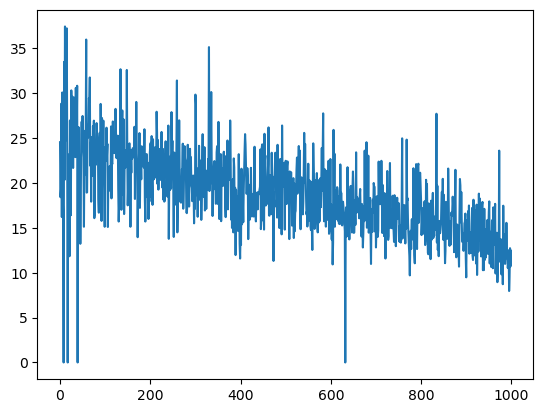

In [102]:
plt.plot(S[inds])

array([ True,  True,  True, ...,  True,  True,  True])